<a href="https://colab.research.google.com/github/Flymshady/traffic_model/blob/main/traffic_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import numpy as np
import matplotlib.pyplot as plt
import os

In [3]:
tf.__version__

'2.3.0'

In [4]:
# white backgrounds plots
import plotly.io as pio
pio.templates.default = 'plotly_white'

In [5]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
fid = drive.ListFile({'q':"title='trafficset.zip'"}).GetList()[0]['id']
f = drive.CreateFile({'id': fid})
f.GetContentFile('trafficset.zip')

In [ ]:
import zipfile

with zipfile.ZipFile("trafficset.zip", 'r') as zip_ref:
  zip_ref.extractall()

# Nová sekce

In [6]:
import cv2
from tqdm import tqdm


In [7]:
DATADIR = '/content/dataset'
CATEGORIES = ["error", "no_traffic", "traffic"]

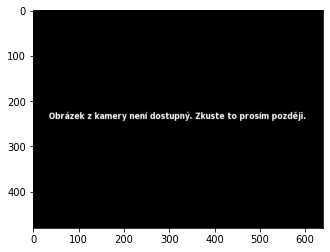

In [8]:
for category in CATEGORIES:
  path = os.path.join(DATADIR, category)
  for img in os.listdir(path):
    img_array =  cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
    plt.imshow(img_array, cmap='gray')
    plt.show()

    break
  break

In [9]:
print(img_array)
print(img_array.shape)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(480, 640)


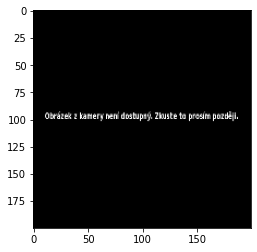

In [10]:
IMG_SIZE = 200
new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
plt.imshow(new_array, cmap='gray')
plt.show()

In [11]:
training_data = []

def create_training_data():
    for category in CATEGORIES:  

        path = os.path.join(DATADIR,category)  
        class_num = CATEGORIES.index(category)  # klasifikace 0-2 error, no_traff, traff

        for img in tqdm(os.listdir(path)):  
            try:
                img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)  
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  
                training_data.append([new_array, class_num])  
            except Exception as e:  
                pass
            #except OSError as e:
            #    print("OSErrroBad img most likely", e, os.path.join(path,img))
            #except Exception as e:
            #    print("general exception", e, os.path.join(path,img))

create_training_data()

print(len(training_data))


100%|██████████| 1819/1819 [00:58<00:00, 30.89it/s]

6959


In [12]:
import random

random.shuffle(training_data)

In [13]:
for sample in training_data[:10]:
    print(sample[1])

1
1
1
2
1
2
1
1
1
2


In [14]:
X = []
y = []

for features,label in training_data:
    X.append(features)
    y.append(label)

print(X[0].reshape(-1, IMG_SIZE, IMG_SIZE, 1))

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)

[[[[ 23]
   [ 20]
   [ 13]
   ...
   [ 27]
   [ 20]
   [ 16]]

  [[ 23]
   [ 22]
   [ 16]
   ...
   [ 24]
   [ 21]
   [ 23]]

  [[ 20]
   [ 18]
   [ 14]
   ...
   [ 22]
   [ 20]
   [ 16]]

  ...

  [[255]
   [254]
   [ 72]
   ...
   [ 94]
   [ 94]
   [ 97]]

  [[255]
   [254]
   [240]
   ...
   [101]
   [ 95]
   [ 95]]

  [[254]
   [254]
   [254]
   ...
   [ 94]
   [102]
   [ 95]]]]


In [15]:
import pickle

pickle_out = open("X.pickle","wb")
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open("y.pickle","wb")
pickle.dump(y, pickle_out)
pickle_out.close()

In [16]:
pickle_in = open("X.pickle","rb")
X = pickle.load(pickle_in)

pickle_in = open("y.pickle","rb")
y = pickle.load(pickle_in)

In [17]:
from tensorflow.keras.datasets import cifar10

In [20]:
pickle_in = open("X.pickle","rb")
X = pickle.load(pickle_in)

pickle_in = open("y.pickle","rb")
y = pickle.load(pickle_in)

X = X/255.0

model = Sequential()

model.add(Conv2D(256, (3, 3), input_shape=X.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

model.add(Dense(64))

model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.fit(X, y, batch_size=32, epochs=10, validation_split=0.3)

ValueError: ignored